In [ ]:
# anomaly_data_generator.py

# Generate synthetic time series data with anomalies for testing anomaly detection.
# Output is formatted for InfluxDB with RFC3339 timestamps.

import numpy as np
import pandas as pd

def generate_anomalous_data():
    """Generate sine wave time series with injected anomalies."""
    # Create timestamps at 1-second intervals
    timestamps = pd.date_range(start="2025-01-01", periods=1000, freq="s")
    
    # Generate clean sine wave
    t = np.linspace(0, 50, 1000)
    clean = np.sin(t)
    
    # Inject anomalies
    anomalous = clean.copy()
    anomalous[100:105] += 4       # Add spike anomaly
    anomalous[500:510] -= 3       # Add dip anomaly
    
    return timestamps, anomalous

def create_influx_csv(timestamps, values, filename="anomaly_scores.csv"):
    """Create InfluxDB-compatible CSV file."""
    df = pd.DataFrame({
        "timestamp": timestamps,
        "value": values
    })
    
    # Format timestamp for InfluxDB
    df['timestamp'] = pd.to_datetime(df['timestamp']).dt.strftime('%Y-%m-%dT%H:%M:%SZ')
    
    # Save to CSV
    df.to_csv(filename, index=False)
    return df

if __name__ == "__main__":
    # Generate data
    timestamps, values = generate_anomalous_data()
    
    # Create CSV file
    df = create_influx_csv(timestamps, values)
    
    # Print summary
    print("\n" + "="*50)
    print("Anomaly Data Generation Complete")
    print("="*50)
    print(f"Output file: 'anomaly_scores.csv'")
    print(f"Total data points: {len(df)}")
    print(f"Time range: {df['timestamp'].iloc[0]} to {df['timestamp'].iloc[-1]}")
    print("\nAnomalies injected:")
    print(f"- Spike at positions 100-104 (timestamp: {df['timestamp'].iloc[100]} to {df['timestamp'].iloc[104]})")
    print(f"- Dip at positions 500-509 (timestamp: {df['timestamp'].iloc[500]} to {df['timestamp'].iloc[509]})")
    print("="*50 + "\n")


Anomaly Data Generation Complete
Output file: 'anomaly_scores.csv'
Total data points: 1000
Time range: 2025-01-01T00:00:00Z to 2025-01-01T00:16:39Z

Anomalies injected:
- Spike at positions 100-104 (timestamp: 2025-01-01T00:01:40Z to 2025-01-01T00:01:44Z)
- Dip at positions 500-509 (timestamp: 2025-01-01T00:08:20Z to 2025-01-01T00:08:29Z)



In [4]:
import numpy as np
import pandas as pd

# Generate data
timestamps = pd.date_range(start="2025-01-01", periods=1000, freq="s")
t = np.linspace(0, 50, 1000)
values = np.sin(t)
values[100:105] += 4  # spike
values[500:510] -= 3  # dip

# Create DataFrame
df = pd.DataFrame({
    "timestamp": pd.to_datetime(timestamps).strftime('%Y-%m-%dT%H:%M:%SZ'),
    "value": values
})

# Save in InfluxDB-compatible format
with open("anomaly_scores.csv", "w") as f:
    f.write("#datatype measurement,timestamp,double\n")
    f.write("sensor_data,timestamp,value\n")
    df.to_csv(f, index=False, header=False)

print("File saved with InfluxDB annotations")

File saved with InfluxDB annotations


In [11]:
# generate_anflux_data.py
import numpy as np
import pandas as pd
from datetime import datetime

# Generate data
timestamps = pd.date_range(start="2025-01-01", periods=1000, freq="s")
values = np.sin(np.linspace(0, 50, 1000))
values[100:105] += 4  # Add spike
values[500:510] -= 3   # Add dip

# Create InfluxDB-ready CSV
with open("anomaly_data_influx.csv", "w") as f:
    # Write annotation header
    f.write("#datatype measurement,timestamp,double\n")
    f.write("anomaly_detection,time,value\n")
    
    # Write data
    for ts, val in zip(timestamps, values):
        f.write(f"anomaly_detection,{ts.isoformat()}Z,{val}\n")

print("CSV generated with:")
print(f"- {len(values)} data points")
print(f"- Annotations for InfluxDB")
print(f"- RFC3339 timestamps with 'Z' timezone")

CSV generated with:
- 1000 data points
- Annotations for InfluxDB
- RFC3339 timestamps with 'Z' timezone


In [19]:
# Use Isolation Forest to Calculate Anomaly Score 
from sklearn.ensemble import IsolationForest

# Fit the model
model = IsolationForest(contamination=0.01, random_state=42)
model.fit(df[['value']])

# Predict anomaly score
df['anomaly_score'] = model.decision_function(df[['value']])
df['anomaly_label'] = model.predict(df[['value']])  # -1 = anomaly


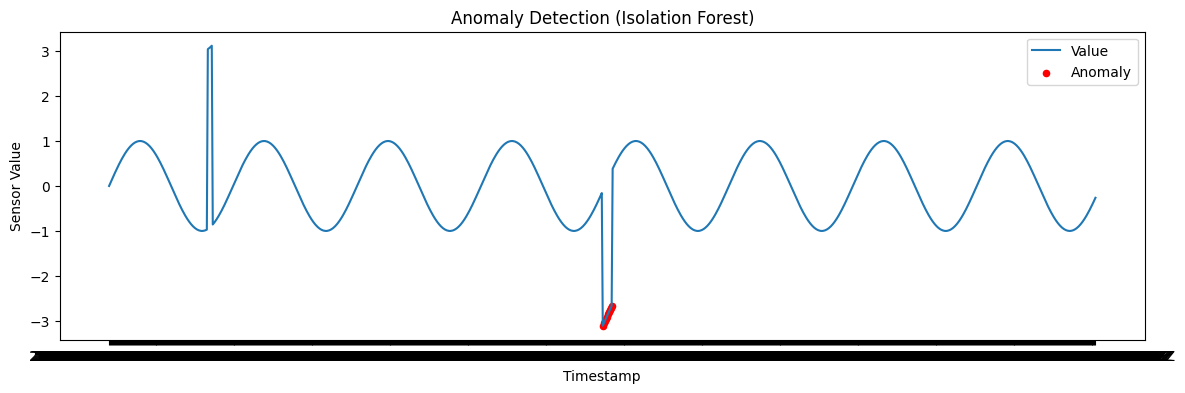

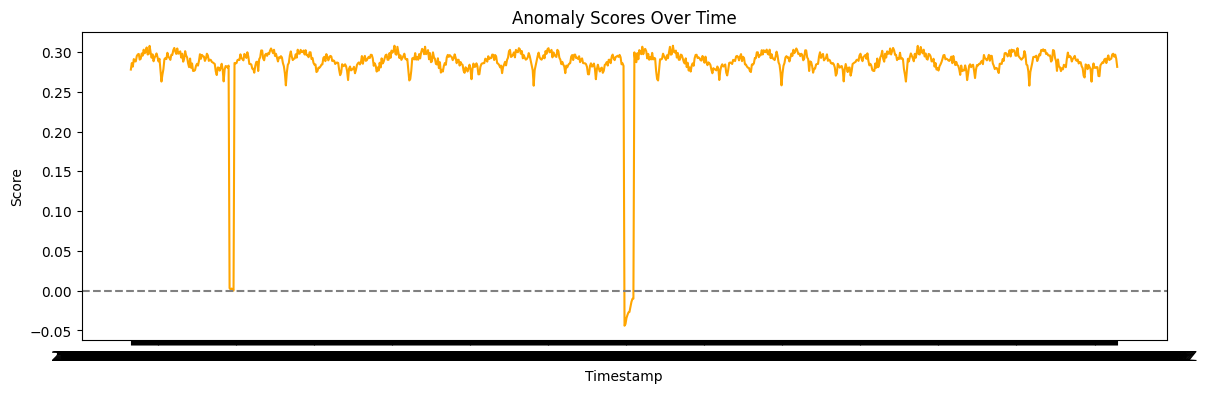

In [20]:
# Visualize Results
import matplotlib.pyplot as plt

# Time-series + anomalies
plt.figure(figsize=(14, 4))
plt.plot(df['timestamp'], df['value'], label="Value")
plt.scatter(df[df['anomaly_label'] == -1]['timestamp'],
            df[df['anomaly_label'] == -1]['value'],
            color='red', label='Anomaly', s=20)
plt.legend()
plt.title("Anomaly Detection (Isolation Forest)")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Value")
plt.show()

# Anomaly score
plt.figure(figsize=(14, 4))
plt.plot(df['timestamp'], df['anomaly_score'], color='orange', label='Anomaly Score')
plt.axhline(y=0, color='gray', linestyle='--')
plt.title("Anomaly Scores Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Score")
plt.show()


In [15]:
# Save to InfluxDB (for Grafana) using Python API

from influxdb_client import InfluxDBClient, Point, WritePrecision

# Define your InfluxDB connection details
url = "http://localhost:8086" 
token = "ybIstwujVFHSoydAAowNfQKoImwGNos0AGqGSbZAjCKtVc9OBHG52XAFqOoGL-Wfs00xlRZiHrvY6ja9JimEJlQ=="
org = "UMU"

# Initialize the client
client = InfluxDBClient(url=url, token=token, org=org)

# Prepare points from DataFrame
points = []
for _, row in df.iterrows():
    point = (
        Point("anomaly_scores")
        .tag("source", "notebook")
        .field("value", float(row["value"]))
        .field("anomaly_score", float(row["anomaly_score"]))
        .field("anomaly_label", int(row["anomaly_label"]))
        .time(row["timestamp"], WritePrecision.S)
    )
    points.append(point)

# Get the write_api from the client
write_api = client.write_api()

# Write to InfluxDB
write_api.write(
    bucket="umu_bucket",
    org="UMU",
    record=points
)